In [1]:
pip install proxop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 4.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
from proxop import AbsValue
import numpy as np

x = np.array([ -3., 1., 6., 3.])
AbsValue().prox(x)
# result: array([-2.,  0.,  5., 2.])

array([-2.,  0.,  5.,  2.])

In [2]:
x

array([-3.,  1.,  6.,  3.])

In [7]:
import numpy as np
import time as time

# Default inputs of the FBPD function
class EmptyFunction:
    def fun(x):      return 0
    def grad(x):     return 0
    def prox(x,tau): return x
    def dir_op(x):   return x
    def adj_op(x):   return x

# Default algorithmic parameters: 'tol' and maximum number of iterations
opt_= {'tol': 1e-4, 'iter': 500}

def FBPD(x_init, f=EmptyFunction(), g=EmptyFunction(), h=EmptyFunction(), opt=opt_):

    # algorithmic parameters
    tol      = opt['tol']
    max_iter = opt['iter']
    
    # step-sizes
    tau   = 2.0 / (g.beta + 2.0)
    sigma = (1.0/tau - g.beta/2.0) / h.beta

    # initialization
    x = x_init
    y = h.dir_op(x)

    print('Running FBPD...')
    
    timing = np.zeros(max_iter)
    criter = np.zeros(max_iter)

    # algorithm loop
    stop=False
    it=0
    while (it < max_iter) and (not stop):
    
        t = time.time()
    
        # primal forward-backward step
        x_old = x;
        x = x - tau * ( g.grad(x) + h.adj_op(y) );
        x = f.prox(x, tau);
    
        # dual forward-backward step
        y = y + sigma * h.dir_op(2*x - x_old);
        y = y - sigma * h.prox(y/sigma, 1/sigma);   

        # time and criterion
        timing[it] = time.time() - t
        criter[it] = f.fun(x) + g.fun(x) + h.fun(h.dir_op(x));
           
        # stopping rule
        if np.linalg.norm(x - x_old) < tol * np.linalg.norm(x_old) and it > 10:
           break
    
        print(str(it)+'out of'+str(max_iter)+'iterations')

    criter = criter[0:it+1];
    timing = np.cumsum(timing[0:it+1]);
    
    return x, it, timing, criter

/var/folders/ks/_91630850zn018jzskzpdw1c0000gp/T/ipykernel_99453/2096728396.py:14: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  z = fil.uniform_filter(x_bar, psf) + 20 * np.random.randn(*x_bar.shape);


Text(0.5, 1.0, 'Noisy image')

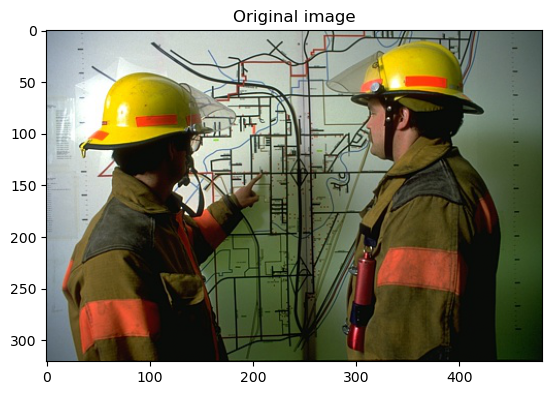

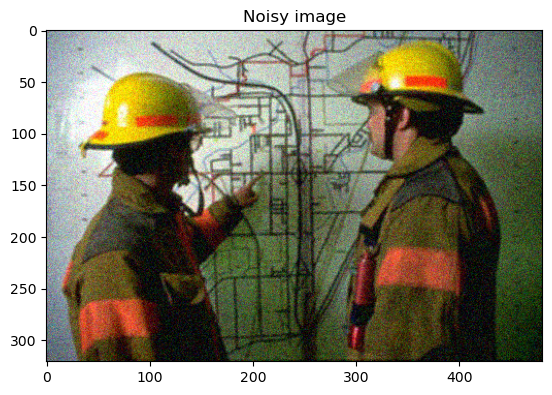

In [8]:
import scipy.ndimage.filters as fil
import matplotlib.pyplot as plt
%matplotlib inline 

# original image
    
x_bar = plt.imread('firemen.jpg')
x_bar = x_bar.astype(np.float64)

# blur operator
psf = (3, 3, 1)

# noisy image
z = fil.uniform_filter(x_bar, psf) + 20 * np.random.randn(*x_bar.shape);

# visualization
plt.imshow(x_bar/255)
plt.title('Original image')
plt.figure()
plt.imshow(np.clip(z/255,0,1))
plt.title('Noisy image')


In [9]:
from proximityOperator import BoxConstraint

class LeastSquares:
    
    def __init__(self, z=None, psf=None):
        self.z    = z
        self.psf  = psf
        self.beta = np.prod(psf)
        
    def A_dir(self, x):
        return fil.uniform_filter(x, self.psf)
    
    def A_adj(self, x):
        return fil.uniform_filter(x, self.psf);     # WARNING: filter dimensions must be odd
    
    def grad(self, x):
        return self.A_adj( self.A_dir(x) - self.z )
    
    def __call__(self, x):
        p = self.A_dir(x)
        return np.sum(np.square(p-z))

# constraint
f = BoxConstraint(0, 255)

# data fidelity
g = LeastSquares(z, psf)

ModuleNotFoundError: No module named 'proximityOperator'

In [10]:
from proximityOperator import L2Norm

def hor_forward(x):
    """ Horizontal forward finite differences (with Neumann boundary conditions) """
    hor = np.zeros_like(x)
    hor[:,:-1,:] = x[:,1:,:] - x[:,:-1,:]
    return hor

def ver_forward(x):
    """ Vertical forward finite differences (with Neumann boundary conditions) """
    ver = np.zeros_like(x)
    ver[:-1,:,:] = x[1:,:,:] - x[:-1,:,:]
    return ver

def hor_backward(x):
    """ Horizontal backward finite differences (with Neumann boundary conditions) """
    Nr, Nc, Nb = x.shape
    zer = np.zeros((Nr,1,Nb))
    xxx = x[:,:-1,:]
    return np.concatenate((zer,xxx), 1) - np.concatenate((xxx,zer), 1)

def ver_backward(x):
    """ Vertical backward finite differences (with Neumann boundary conditions) """
    Nr, Nc, Nb = x.shape
    zer = np.zeros((1,Nc,Nb))
    xxx = x[:-1,:,:]
    return np.concatenate((zer,xxx), 0) - np.concatenate((xxx,zer), 0)


class TotalVariation(L2Norm):

    beta = 8
    
    def __init__(self, gamma):
        L2Norm.__init__(self, gamma, direction=3)
    
    def dir_op(self, x):
        h = hor_forward(x)
        v = ver_forward(x)
        return np.stack((h,v), 3)
    
    def adj_op(self, y):
        h = hor_backward( y[:,:,:,0] )
        v = ver_backward( y[:,:,:,1] )
        return h + v
    
    #def fun(self, x)  --> inherited from L2_Norm
    #def prox(self, x) --> inherited from L2_Norm

# hyperparameter
gamma = 5

# regularization
h = TotalVariation(gamma)  

ModuleNotFoundError: No module named 'proximityOperator'

In [11]:
# minimization
x, it, time_, crit = FBPD(z, f, g, h)

# PSNR
psnr = 10 * np.log10( 255*255 / np.mean(np.square(x-x_bar)) )

# visualization
plt.imshow(x/255); 
plt.title( 'Restored image - PSNR: ' + str(np.round(psnr,2)) )
plt.figure()
plt.plot(time_, crit) 
plt.title('Convergence plot')
plt.xlabel('seconds')
plt.ylabel('criterion')

NameError: name 'f' is not defined